In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = 'data/data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['zero', 'four', 'three', 'right', 'cat', 'tree', 'happy', 'one', 'wow', 'up', 'down', 'house', 'marvin', 'two', 'yes', 'nine', 'bird', 'learn', 'sheila', 'dog', 'bed', 'eight', 'on', 'stop', 'left', 'forward', 'six', 'off', 'visual', 'five', 'backward', 'go', 'no', 'seven', 'follow']


In [3]:
# Settings
feature_sets_path = '.'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77439, 16, 16)
(9726, 16, 16)
(9691, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[ 9. 16. 32. ... 15. 17. 21.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03824799506477483
0.9617520049352252


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(77439, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77439, 16, 16, 1)
(9726, 16, 16, 1)
(9691, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
775/775 [==============================] - 6s 7ms/step - loss: 0.1619 - acc: 0.9531 - val_loss: 0.0861 - val_acc: 0.9745
Epoch 2/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0880 - acc: 0.9702 - val_loss: 0.0781 - val_acc: 0.9792
Epoch 3/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0684 - acc: 0.9789 - val_loss: 0.0782 - val_acc: 0.9806
Epoch 4/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0595 - acc: 0.9824 - val_loss: 0.0590 - val_acc: 0.9833
Epoch 5/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0590 - acc: 0.9823 - val_loss: 0.0666 - val_acc: 0.9833
Epoch 6/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0539 - acc: 0.9843 - val_loss: 0.0557 - val_acc: 0.9841
Epoch 7/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0557 - acc: 0.9832 - val_loss: 0.1064 - val_acc: 0.9603
Epoch 8/30
775/775 [==============================] - 5s 6ms/step - loss: 0.

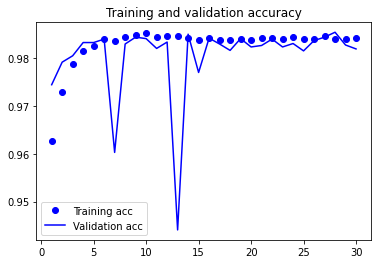

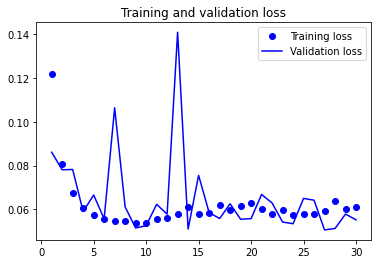

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

97
100
135
230
293
331
354
367
392
406
440
445
448
452
482
495
527
533
586
612
679
685
722
736
871
880
910
911
955
960
984
1034
1037
1053
1081
1091
1118
1149
1152
1170
1182
1192
1221
1244
1287
1307
1320
1334
1337
1354
1363
1367
1383
1391
1400
1464
1481
1489
1508
1521
1539
1561
1624
1628
1693
1735
1776
1852
1870
1977
1989
1992
2055
2067
2097
2098
2107
2119
2149
2191
2208
2300
2304
2309
2313
2321
2326
2339
2348
2352
2414
2432
2470
2474
2488
2631
2725
2744
2797
2803
2822
2825
2853
2854
2862
2876
2891
2902
2904
2919
2923
3007
3060
3079
3082
3110
3142
3148
3159
3161
3257
3274
3279
3281
3379
3398
3502
3511
3521
3528
3530
3549
3550
3553
3580
3674
3700
3701
3769
3785
3829
3831
3836
3848
3860
3865
3867
3971
3984
4015
4024
4086
4093
4212
4251
4257
4327
4377
4385
4493
4496
4508
4511
4531
4616
4626
4646
4667
4697
4701
4759
4771
4800
4802
4859
4893
4929
5017
5041
5109
5139
5177
5197
5218
5233
5255
5303
5313
5333
5362
5373
5428
5430
5492
5540
5560
5565
5584
5652
5681
5698
5715
5722
5729
5737
5740
57

In [21]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[0.92442906]]
Answer: 0.0  Prediction: [[0.01127735]]
Answer: 0.0  Prediction: [[0.01806501]]
Answer: 0.0  Prediction: [[7.3005813e-06]]
Answer: 0.0  Prediction: [[1.394443e-05]]
Answer: 0.0  Prediction: [[0.00768739]]
Answer: 0.0  Prediction: [[0.00236255]]
Answer: 0.0  Prediction: [[0.00034595]]
Answer: 0.0  Prediction: [[1.2219827e-21]]
Answer: 0.0  Prediction: [[0.02372068]]


In [22]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 1s 1ms/step - loss: 0.0614 - acc: 0.9844


[0.06141199916601181, 0.984418511390686]

In [25]:
# for x in x_train[y_train == 1]:
#     print(model.predict(np.expand_dims(x, 0)))